In [1]:
from mongo_wrapper.mongo_wrapper import MongoWrapper
import os
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import nltk
from gensim import corpora, models
import string
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from collections import Counter, defaultdict
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

True

In [2]:
# combine data from different collections in MongoDB: articles from Google News and articles from MediaCloud
def combine(mcloud: pd.DataFrame, gnews: pd.DataFrame, state: str) -> pd.DataFrame:
    gnews['source'] = 'gnews'
    mcloud['source'] = 'mcloud'
    
    # ensure same columns exist in both dataframes
    all_columns = set(gnews.columns) | set(mcloud.columns)
    for col in all_columns:
        if col not in gnews.columns:
            gnews[col] = None
        if col not in mcloud.columns:
            mcloud[col] = None
    
    # combine the dataframes
    combined = pd.concat([gnews, mcloud], ignore_index=True)
    combined['year'] = combined['date'].dt.year
    
    # keep only articles from 2020 and 2022
    target_years = [2020, 2022]
    combined_filtered = combined[combined['year'].isin(target_years)]
    
    # check how many articles are in each year-state combination
    print(f"\\n{state} - summary for 2020 and 2022:")
    
    for year in target_years:
        year_data = combined_filtered[combined_filtered['year'] == year]
        
        if not year_data.empty:
            mcloud_count = len(year_data[year_data['source'] == 'mcloud'])
            gnews_count = len(year_data[year_data['source'] == 'gnews'])
            total_count = len(year_data)
            
            print(f"  {year}:")
            print(f"    MediaCloud: {mcloud_count} articles")
            print(f"    Google News: {gnews_count} articles")
            print(f"    Total: {total_count} articles")
        else:
            print(f"  {year}: 0 articles")
    
    return combined_filtered

In [3]:
def process_state_data(state: str, mongo_client: MongoWrapper) -> pd.DataFrame:
    print(f"\\nProcessing {state}...")
    
    # get data from MongoDB collections
    # data from Google News
    try:
        gnews_data = mongo_client.get_collection_entries(f'gnews_{state}')
        gnews_df = pd.DataFrame(gnews_data)
    except Exception as e:
        print(f"  Error getting Google News data for {state}: {e}")
        gnews_df = pd.DataFrame()
    
    # data from MediaCloud
    try:
        mcloud_data = mongo_client.get_collection_entries(f'mediacloud_{state}')
        mcloud_df = pd.DataFrame(mcloud_data)
    except Exception as e:
        print(f"  Error getting MediaCloud data for {state}: {e}")
        mcloud_df = pd.DataFrame()
    
    # handle the date columns 
    # handle Google News dates
    try:
        gnews_df["date"] = pd.to_datetime(gnews_df["published date"], format='%a, %d %b %Y %H:%M:%S GMT')
        gnews_df = gnews_df.drop(columns=['published date'])
    except Exception as e:
        print(f"  Error processing Google News dates for {state}: {e}")
        gnews_df = pd.DataFrame()
    
    # handle MediaCloud dates
    try:
        mcloud_df['date'] = pd.to_datetime(mcloud_df['publish_date'])
        mcloud_df['date_str'] = mcloud_df['date'].dt.strftime('%a, %d %b %Y 08:00:00 GMT')
        mcloud_df['date'] = pd.to_datetime(mcloud_df['date_str'], format='%a, %d %b %Y %H:%M:%S GMT')
        mcloud_df = mcloud_df.drop(columns=['publish_date', 'date_str'])
    except Exception as e:
        print(f"  Error processing MediaCloud dates for {state}: {e}")
        mcloud_df = pd.DataFrame()
    
    # combine the dataframes
    combined = combine(mcloud_df, gnews_df, state)
    return combined

In [4]:
# preprocess the contents 
lemm = spacy.load('es_core_news_md')

# define custom stopwords to add to default ones 
custom_stopwords = {
    'él', 'ella', 'ellos', 'ellas', 'le', 'la', 'lo', 'les', 'las', 'los', 'sino', 'querétaro', 'municipio',
    'año', 'mes', 'día', 'tiempo', 'momento', 'semana', '2020', '2021', '2022', '2023', '2024', '2025', 'méxico',
    'mil', 'ciento', 'millón', 'dólares', 'tener', 'hacer', 'ver', 'ir', 'llegar', 'mexicano', 'secretaría',
    'salir', 'seguir', 'entre', 'sobre', 'tras', 'mediante', 'durante', 'aunque', 'ciudad', 'lugar', 'grupo', 
    'nacional', 'persona', 'caso', 'entidad', 'the', 'país', 'público', 'general', 'lópez', 'dejar', 'decidir',
    'gobierno', 'presidente', 'chihuahua', 'california', 'león', 'durango', 'coahuila', 'puebla', 'pasar', 'región'
    'luis', 'san', 'roo', 'veracruz', 'aguascalientes', 'baja', 'sur', 'potosí', 'sinaloa', 'municipal', 'norte',
    'campeche', 'chiapas', 'colima', 'estado', 'guanajuato', 'ciudad', 'estado', 'quintana', 'contar', 'querer',
    'guerrero', 'hidalgo', 'jalisco', 'michoacán', 'morelos', 'nayarit', 'nuevo', 'zona', 'centro', 'deber', 'recibir',
    'sonora', 'tabasco', 'tamaulipa', 'tlaxcala', 'yucatán', 'zacateca', 'oaxaca', 'encontrar', 'ofrecer', 'zacatecas'}

ALL_STOP_WORDS = STOP_WORDS.union(custom_stopwords)

# function to preprocess 
def preprocess(text):
    text = text.lower() # lowercase 
    doc = lemm(text)
    tokens = [
        token.lemma_ for token in doc 
        if token.lemma_ not in ALL_STOP_WORDS # remove stopwords (default and custom)
        and not token.is_punct # remove punctuation
        and not token.is_digit # remove numbers 
        and not any(char.isdigit() for char in token.text) # remove tokens with digits
        and len(token.lemma_.strip()) > 2 # remove too short tokens
        and token.lemma_.strip() != ''] # remove empty tokens
    return " ".join(tokens)

def clean_and_preprocess_data(state_dfs: dict) -> dict:
    state_dfs_cleaned = {}
    
    for state, df in state_dfs.items():
        try:
            df_cleaned = df.copy()
            # Preprocess text
            df_cleaned['text_cleaned'] = df_cleaned['content'].astype(str).apply(preprocess)
            # Count words
            df_cleaned['word_count'] = df_cleaned['text_cleaned'].apply(lambda x: len(x.split()))
            # Remove short articles
            df_cleaned = df_cleaned[df_cleaned['word_count'] >= 10]
            
            state_dfs_cleaned[state] = df_cleaned
            print(f"Cleaned {state}: {len(df_cleaned)} articles remaining")
        except Exception as e:
            print(f"Error cleaning {state}: {e}")
    
    return state_dfs_cleaned

In [5]:
def combined_data(state_dfs_cleaned: dict, target_years: list = [2020, 2022]) -> dict:
    combined_state_data = {}
    
    # extract unique states from keys like "State_2020", "State_2022"
    states = set([key.rsplit('_', 1)[0] for key in state_dfs_cleaned.keys()])
    
    for state in states:
        combined_texts = []
        year_labels = []
        
        for year in target_years:
            key = f"{state}_{year}"
            if key in state_dfs_cleaned:
                df = state_dfs_cleaned[key]
                texts = df['text_cleaned'].tolist()
                combined_texts.extend(texts)
                year_labels.extend([year] * len(texts))
        
        if combined_texts:
            combined_state_data[state] = {
                'texts': combined_texts, 
                'years': year_labels}
    
    return combined_state_data

In [6]:
# run LDA on the combined data (2020 and 2022 together - so one model per state)
def run_lda(combined_state_data: dict) -> dict:
    lda_results = {}
    
    for state, data in combined_state_data.items():
        texts = data['texts']
        years = data['years']
            
        # CountVectorize texts 
        cv = CountVectorizer(ngram_range=(1, 3), lowercase=False, min_df=0.001, max_df=0.6, 
                             stop_words=list(ALL_STOP_WORDS), token_pattern=r'\b[a-záéíóúñü]{3,}\b')
            
        vectorized_text = cv.fit_transform(texts)
        dtm_sparse = csr_matrix(vectorized_text)
        corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)
            
        # gensim dictionary   
        vocabulary_gensim = {val: key for key, val in cv.vocabulary_.items()}
        dictionary = corpora.Dictionary()
        dictionary.id2token = vocabulary_gensim
        dictionary.token2id = cv.vocabulary_
            
        # define LDA model
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, 
                                    passes=20, random_state=42, eta=0.001, alpha=0.001)
            
        # save the model 
        lda_results[state] = { "model": lda_model, "corpus": corpus, "dictionary": dictionary, "years": years, "texts": texts}
        
        print(f"LDA completed for {state}")
        
    return lda_results

In [7]:
def calculate_topic_shares(lda_results: dict, target_years: list = [2020, 2022]) -> dict:
    year_topic_shares = {}
    
    for year in target_years:
        year_topic_shares[year] = {}
        
        for state, data in lda_results.items():
            model = data["model"]
            corpus = data["corpus"]
            years = data["years"]
            
            # filter documents for the specific year
            year_indices = [i for i, y in enumerate(years) if y == year]
            
            if year_indices:
                topic_dist = np.zeros(model.num_topics)
                doc_count = 0
                
                for idx in year_indices:
                    doc = corpus[idx]
                    doc_topics = model[doc]
                    doc_count += 1
                    
                    for topic_id, prob in doc_topics:
                        topic_dist[topic_id] += prob
                
                if doc_count > 0:
                    topic_dist = topic_dist / doc_count
                
                year_topic_shares[year][state] = topic_dist
                print(f"Topic shares calculated for {state} - {year}")
    
    return year_topic_shares

def save_results(lda_results: dict, year_topic_shares: dict, target_years: list = [2020, 2022]):
    # save distributiona of topics - one per year
    for year in target_years:
        if year in year_topic_shares and year_topic_shares[year]:
            df_shares = pd.DataFrame.from_dict(year_topic_shares[year], orient='index')
            df_shares.columns = [f'Topic_{i}' for i in range(df_shares.shape[1])]
            df_shares.to_csv(f'shares_{year}_improved2.csv')
    
    # save keywords for each state - one csv only since is one LDA model per state but per both years
    all_keywords = {}
    
    for state, data in lda_results.items():
        model = data["model"]
        state_topics = {}

        for topic_id in range(model.num_topics):
            top_words = model.show_topic(topic_id, topn=50)
            words = [word for word, _ in top_words]
            state_topics[f'Topic_{topic_id}'] = ', '.join(words)
        
        all_keywords[state] = state_topics

    if all_keywords:
        df_keywords = pd.DataFrame.from_dict(all_keywords, orient='index')
        df_keywords.to_csv('keywords_all_states_improved.csv')

In [8]:
def pipeline():
    # connect to MongoDB
    mongo_client = MongoWrapper(
        db="news_outlets",
        user=os.getenv("MONGO_USERNAME"),
        password=os.getenv("MONGO_PASSWORD"),
        ip=os.getenv("MONGO_IP"),
        port=os.getenv("MONGO_PORT"))
    
    # Mexican states
    states = [
        "Aguascalientes", "Baja California", "Baja California Sur", "Campeche", "Chiapas", "Chihuahua",
        "Coahuila", "Colima", "Durango", "Guanajuato", "Guerrero", "Hidalgo", "Jalisco", "Mexico",
        "Michoacan", "Morelos", "Nayarit", "Nuevo Leon", "Oaxaca", "Puebla", "Queretaro", "Quintana Roo",
        "San Luis Potosi", "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz",
        "Yucatan", "Zacatecas", "Ciudad de México"]

    
    # years to analyze
    target_years = [2020, 2022]

    # retrieve data for each state
    state_raw_dfs = {}
    
    for state in states:
        combined_df = process_state_data(state, mongo_client)
        
        if not combined_df.empty:
            # split by years
            for year in target_years:
                year_data = combined_df[combined_df['year'] == year].copy()
                if not year_data.empty:
                    state_year_key = f"{state}_{year}"
                    state_raw_dfs[state_year_key] = year_data
    
    print(f"\\nTotal state-year combinations: {len(state_raw_dfs)}")
    
    # preprocessing
    state_dfs_cleaned = clean_and_preprocess_data(state_raw_dfs)
    
    # combine data for LDA
    combined_state_data = combined_data(state_dfs_cleaned, target_years)
    
    # run LDA
    lda_results = run_lda(combined_state_data)
    
    # calculate topic shares and save results 
    year_topic_shares = calculate_topic_shares(lda_results, target_years)
    save_results(lda_results, year_topic_shares, target_years)
    
    return lda_results, year_topic_shares

lda_results, year_topic_shares = pipeline()

2025-05-29 15:47:31,989 WARNING Logger Mongo was configured with True console stream
2025-05-29 15:47:32,336 INFO Connected to news_outlets database on 206.81.16.39


\nProcessing Aguascalientes...
\nAguascalientes - summary for 2020 and 2022:
  2020:
    MediaCloud: 2000 articles
    Google News: 2014 articles
    Total: 4014 articles
  2022:
    MediaCloud: 1998 articles
    Google News: 2462 articles
    Total: 4460 articles
\nProcessing Baja California...
\nBaja California - summary for 2020 and 2022:
  2020:
    MediaCloud: 2000 articles
    Google News: 2069 articles
    Total: 4069 articles
  2022:
    MediaCloud: 3995 articles
    Google News: 3010 articles
    Total: 7005 articles
\nProcessing Baja California Sur...
\nBaja California Sur - summary for 2020 and 2022:
  2020:
    MediaCloud: 3000 articles
    Google News: 926 articles
    Total: 3926 articles
  2022:
    MediaCloud: 1998 articles
    Google News: 2163 articles
    Total: 4161 articles
\nProcessing Campeche...
\nCampeche - summary for 2020 and 2022:
  2020:
    MediaCloud: 2000 articles
    Google News: 1229 articles
    Total: 3229 articles
  2022:
    MediaCloud: 1998 articl

In [11]:
df = pd.read_csv('news_data/keywords_all_states_improved.csv', index_col=0)

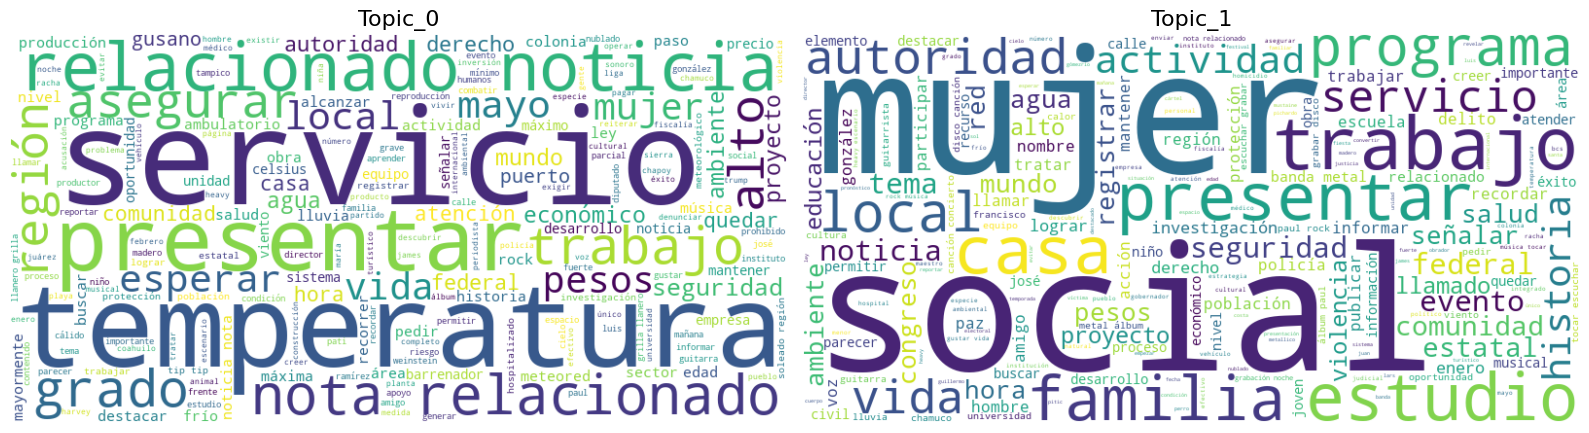

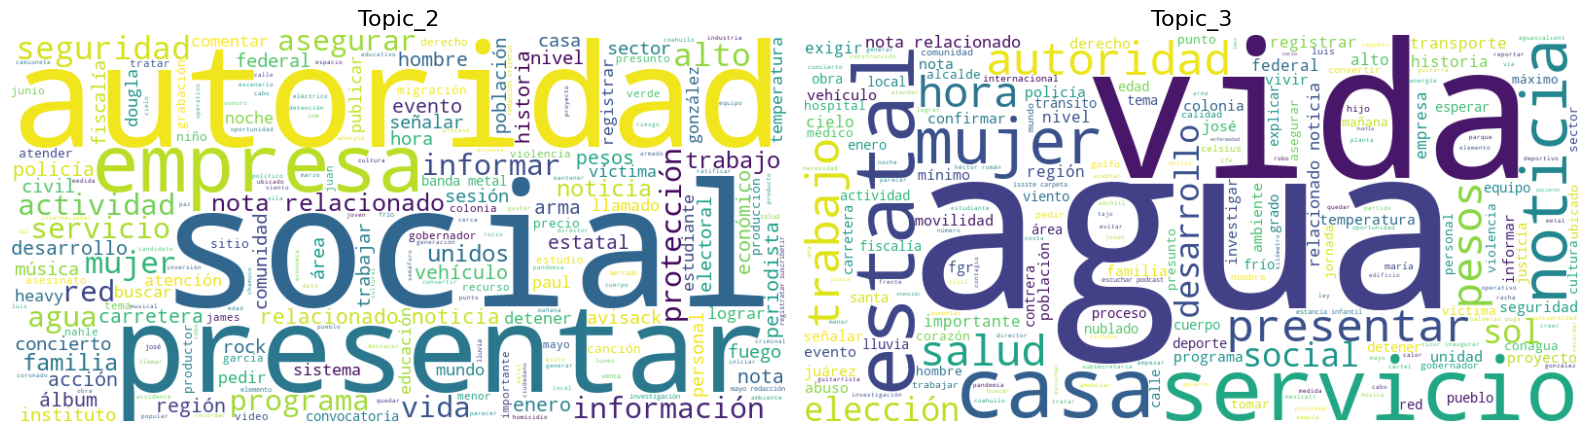

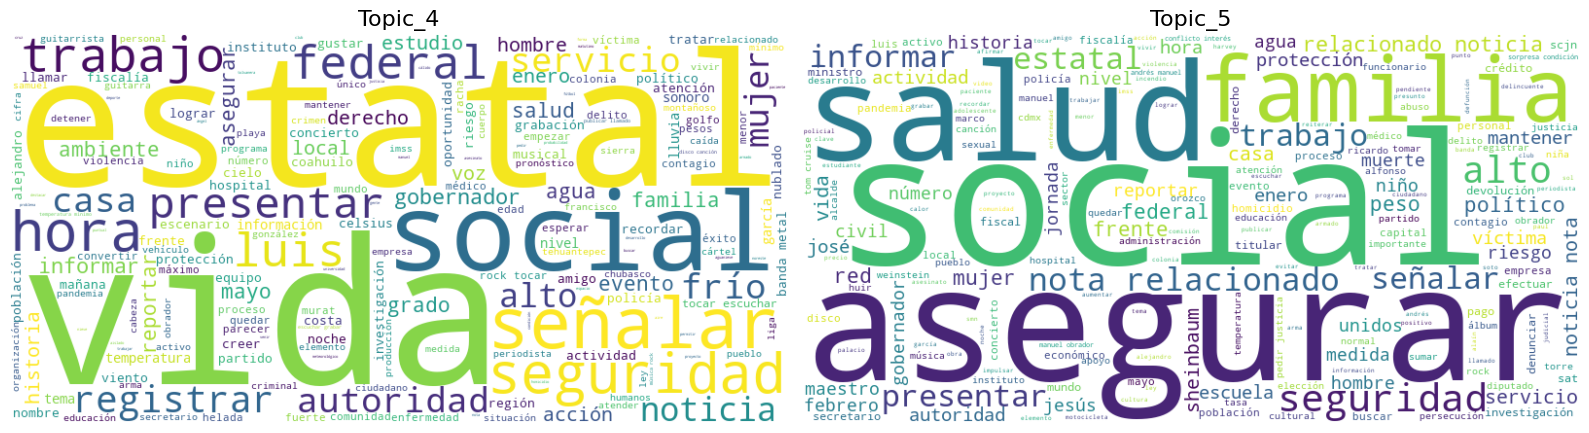

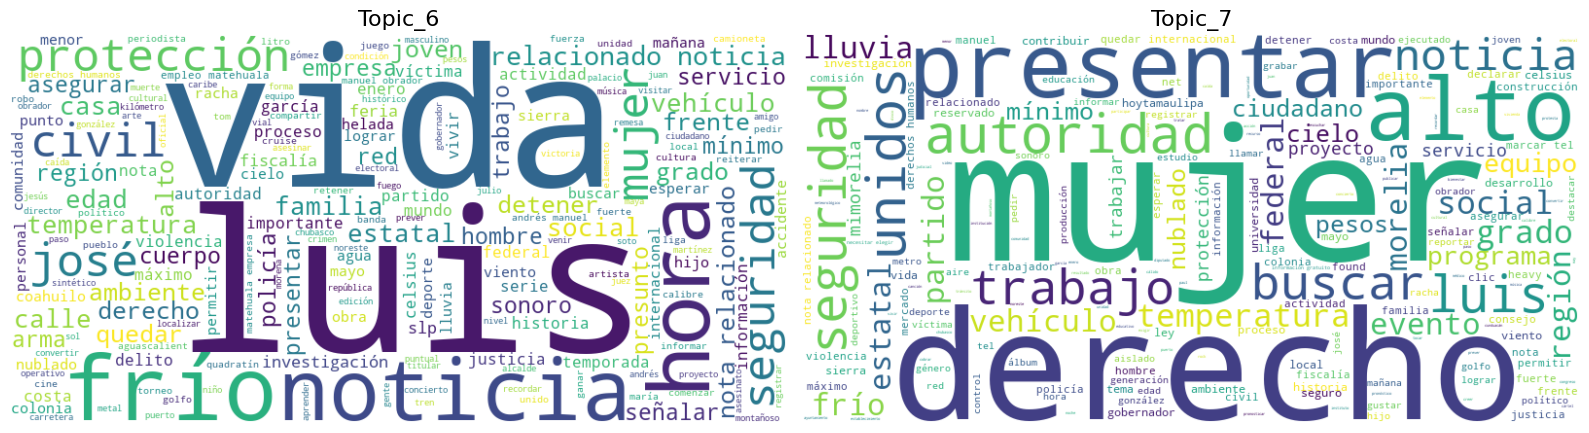

In [12]:
topic_cols_2020 = [col for col in df.columns if col.startswith("Topic_")]
for i in range(0, len(topic_cols_2020), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for j in range(2):
        if i + j < len(topic_cols_2020):
            col = topic_cols_2020[i + j]
            text = ' '.join(df[col].dropna().tolist())
            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
            axes[j].imshow(wordcloud, interpolation='bilinear')
            axes[j].axis('off')
            axes[j].set_title(col, fontsize=16)
    plt.tight_layout()
    plt.show()